# Image Denoiser

**Esther SunYoung CHOI**

Our goal is to use Keras to train an autoencoder to denoise images from the MNIST dataset that contains 28x28 pixels images of handwritten digits.

## Prerequisite Python Modules

Let's first import some Python softwares.

In [ ]:
import random

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from keras.datasets import mnist     # MNIST dataset included in Keras
from keras.models import Sequential # Model type to be used
from keras import layers # Types of layers to be used in our model

import pandas as pd

## Loading training data

The following cell loads the MNIST dataset. It contains 60,000 training images and 10,000 validation images.

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using Matplotlib, we can display a few images from the training set.

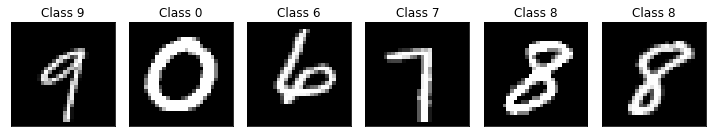

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(6):
    ax = plt.subplot(1,6,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

Our model will take as input a 1-dimensional 784-length vector of a 28x28 pixels. Each image then needs to be reshaped, and we will rescale the values to $[0,1]$.

In [ ]:
img_size = 784
X_train,X_test = X_train.reshape(-1,img_size),X_test.reshape(-1,img_size)
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

As our goal is to perform image denoising, the input data will have to be noised images and output images should be similar to the original clean images.

We will artificially noise images by adding some random number to the different pixels.

In [ ]:
noise_factor = 0.3
X_train_noisy = np.clip(X_train + noise_factor * np.random.randn(X_train.shape[0],X_train.shape[1]),0.0,1.0)
X_test_noisy = np.clip(X_test + noise_factor * np.random.randn(X_test.shape[0],X_test.shape[1]),0.0,1.0)

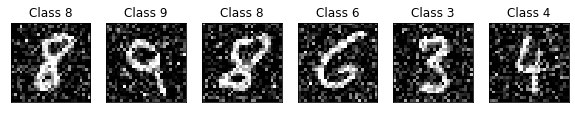

In [ ]:
plt.figure(figsize=(10, 4))
for i in range(6):
    ax = plt.subplot(1,6,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train_noisy[num].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

## Building and Training the model

Now that we have loaded our dataset, we are going to build and train our autoencoder.

The model we will consider is very simple :  the encoder and the decoder will only consist of one linear unit and an activation layer. We will set the dimension of the latent space to 128.

We will use the ReLU function as the activation of the encoder, and in order to push output values towards 0 and 1, we will use the sigmoid function as the decoder activation layer.
The architecture is as follows :
```
Encoder : Input (dimension 784) > Linear Unit (dimension 128) > ReLU activation
Decoder : Coded image (dimension 128) > Linear Unit (dimension 784) > Sigmoid activation
```


In [ ]:
encoding_dim = 128

# Layers
input_img = keras.Input(shape=(img_size,))
encoded = layers.Dense(units=encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(units=img_size, activation='sigmoid')(encoded)

# Model
autoencoder = keras.Model(input_img,decoded)  # Maps an input to its reconstruction

# Encoder model
encoder = keras.Model(input_img,encoded)  # Maps an input to its latent representation

# Decoder model
encoded_input = keras.Input(shape=(encoding_dim,))  # Encoded (128-dimensional) input
decoder_layer = autoencoder.layers[-1]  # Retrieve the last layer of the autoencoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))  # Maps the latent representation to the reconstruction

Let's now train our autoencoder. To do so, we will use the binary cross-entropy loss with the SGD optimizer with a learning rate of 0.2, and train on 50 epochs of 128 batches.

In [ ]:
autoencoder.compile(optimizer=keras.optimizers.SGD(learning_rate=0.15),loss='binary_crossentropy')

history = autoencoder.fit(X_train_noisy,X_train,validation_data=(X_test_noisy,X_test),batch_size=128,epochs=50)

Epoch 1/50
469/469 [==============================] - 7s 13ms/step - loss: 0.4242 - val_loss: 0.2790
Epoch 2/50
469/469 [==============================] - 6s 13ms/step - loss: 0.2735 - val_loss: 0.2693
Epoch 3/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2677 - val_loss: 0.2651
Epoch 4/50
469/469 [==============================] - 6s 13ms/step - loss: 0.2636 - val_loss: 0.2608
Epoch 5/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2590 - val_loss: 0.2556
Epoch 6/50
469/469 [==============================] - 6s 14ms/step - loss: 0.2533 - val_loss: 0.2493
Epoch 7/50
469/469 [==============================] - 5s 11ms/step - loss: 0.2466 - val_loss: 0.2421
Epoch 8/50
469/469 [==============================] - 7s 14ms/step - loss: 0.2393 - val_loss: 0.2345
Epoch 9/50
469/469 [==============================] - 6s 13ms/step - loss: 0.2320 - val_loss: 0.2272
Epoch 10/50
469/469 [==============================] - 6s 12ms/step - loss: 0.2251 - val_lo

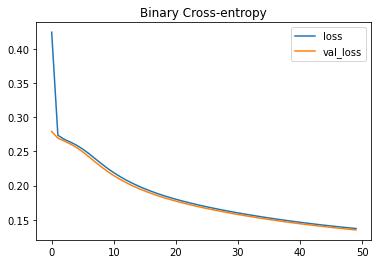

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Binary Cross-entropy")

## Visualizing the result

We can now apply our model to reconstruct images from the noised test data.

In the following plot, the first line shows the original clean images, the second line shows the noised image and the third line shows the images denoised by the model.

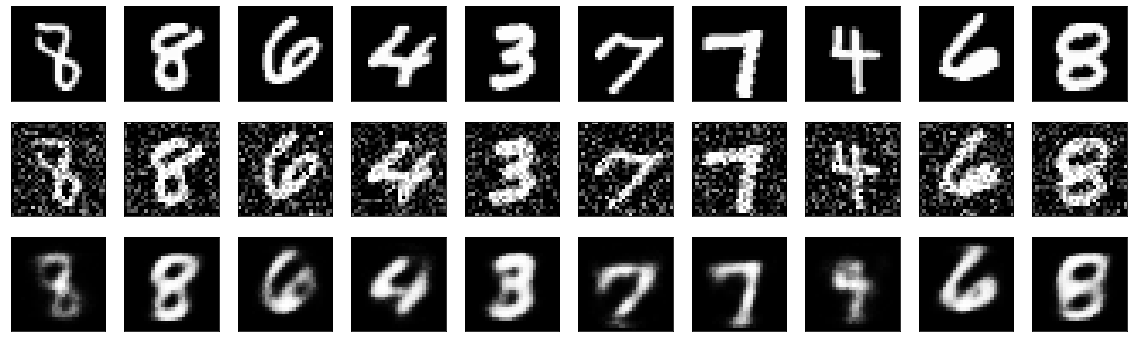

In [ ]:
# Encode and decode some digits from the test dataset
encoded_imgs = encoder.predict(X_test_noisy)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  # How many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    num = random.randint(0,X_test.shape[0])

    # Display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[num].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Noised
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(X_test_noisy[num].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(decoded_imgs[num].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Improvements

We can use the Adam optimizer (with default paramaters) to reduce the traning time, as it converges faster.

In [ ]:
encoding_dim = 128

# Layers
input_img = keras.Input(shape=(img_size,))
encoded = layers.Dense(units=encoding_dim, activation='relu')(input_img)
decoded = layers.Dense(units=img_size, activation='sigmoid')(encoded)

# Model
autoencoder_adam = keras.Model(input_img,decoded)  # Maps an input to its reconstruction

# Encoder model
encoder_adam = keras.Model(input_img,encoded)  # Maps an input to its encoded representation

# Decoder model
encoded_input_adam = keras.Input(shape=(encoding_dim,))  # Encoded (32-dimensional) input
decoder_layer_adam = autoencoder_adam.layers[-1]  # Retrieve the last layer of the autoencoder model
decoder_adam = keras.Model(encoded_input_adam, decoder_layer_adam(encoded_input_adam))  # Create the decoder model
                                                                    # Maps the latent representation to the reconstruction

In [ ]:
#autoencoder_adam.compile(optimizer=keras.optimizers.Adam(learning_rate=0.2),loss='binary_crossentropy')
autoencoder_adam.compile(optimizer='adam',loss='binary_crossentropy')
history_noisy_adam = autoencoder_adam.fit(X_train_noisy,X_train,validation_data=(X_test_noisy,X_test),batch_size=128,epochs=10)

Epoch 1/10
469/469 [==============================] - 6s 12ms/step - loss: 0.1821 - val_loss: 0.1222
Epoch 2/10
469/469 [==============================] - 6s 12ms/step - loss: 0.1111 - val_loss: 0.1012
Epoch 3/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0986 - val_loss: 0.0946
Epoch 4/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0936 - val_loss: 0.0912
Epoch 5/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0907 - val_loss: 0.0890
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0887 - val_loss: 0.0876
Epoch 7/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0875 - val_loss: 0.0868
Epoch 8/10
469/469 [==============================] - 5s 12ms/step - loss: 0.0866 - val_loss: 0.0862
Epoch 9/10
469/469 [==============================] - 5s 11ms/step - loss: 0.0859 - val_loss: 0.0855
Epoch 10/10
469/469 [==============================] - 6s 12ms/step - loss: 0.0854 - val_lo

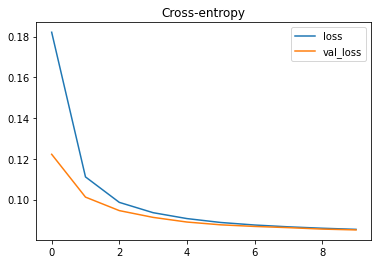

In [ ]:
history_df_adam = pd.DataFrame(history_noisy_adam.history)
history_df_adam.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")

We can also see that the loss is smaller compared to the SGD.

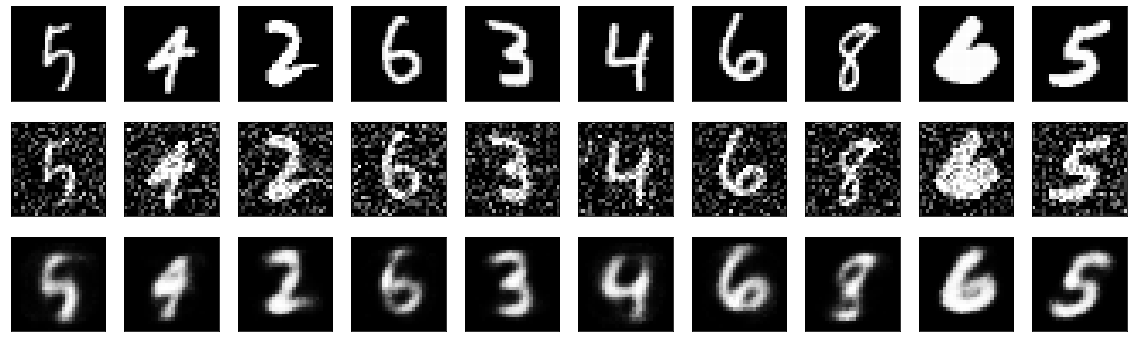

In [ ]:
# Encode and decode some digits from the test dataset
encoded_imgs_adam = encoder_adam.predict(X_test_noisy)
decoded_imgs_adam = decoder_adam.predict(encoded_imgs_adam)


n = 10  # How many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    num = random.randint(0,X_test.shape[0])

    # Display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(X_test[num].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Noised
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(X_test_noisy[num].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(decoded_imgs[num].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Testing our model

To test the effectiveness of our denoising model, we can try to see if a classification model trained on the clean data is able to correctly classify denoised images.

## Limits of the model

This autoencoder is trained to reconstruct images that are a little noisy (we previously set the noise factor to 0.3). To test the limits of our model, we can try to denoise images that contain much more noise.

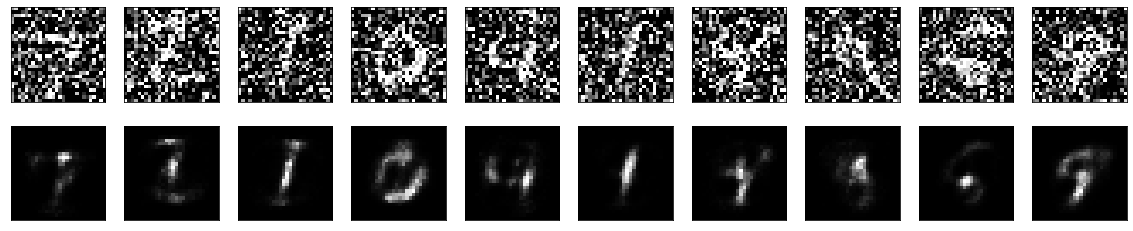

In [ ]:
noise_factor = 0.7
X_test_verynoisy = np.clip(X_test[:10] + noise_factor * np.random.randn(X_test[:10].shape[0],X_test[:10].shape[1]),0.0,1.0)

# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs_verynoisy = encoder.predict(X_test_verynoisy)
decoded_imgs_verynoisy = decoder.predict(encoded_imgs_verynoisy)


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test_verynoisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs_verynoisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

We can still read the numbers but they are not very clear.

Moreover, we can't use our autoencoder to denoise images containing something else than digits.

In [ ]:
from keras.datasets import fashion_mnist

(_, _), (fa_X_test, fa_y_test) = fashion_mnist.load_data()

print("X_test shape", fa_X_test.shape)
print("y_test shape", fa_y_test.shape)

X_test shape (10000, 28, 28)
y_test shape (10000,)


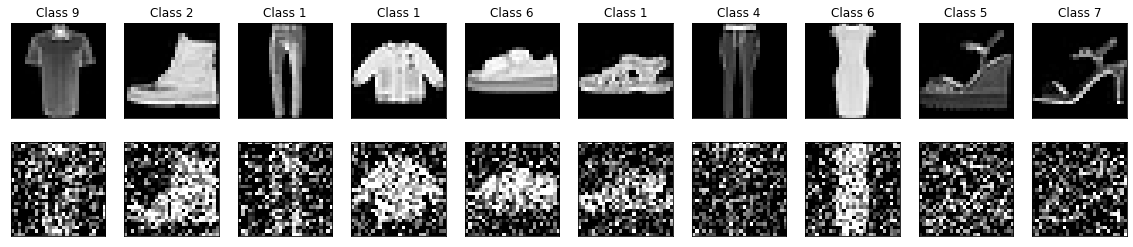

In [ ]:
fa_X_test = fa_X_test.reshape(-1,784).astype('float32')/255

k = 10 # number images to test
id = [random.randint(0,fa_X_test.shape[0]) for i in range(k)]

noise_factor = 0.5
fa_X_test_noisy = np.clip(fa_X_test[id] + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=fa_X_test[id].shape), 0., 1.)

plt.figure(figsize=(20, 4))
for i in range(k):
    # Display original
    ax = plt.subplot(2,k,i+1)
    plt.imshow(fa_X_test[id[i]].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Class {}".format(fa_y_test[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display noised
    ax = plt.subplot(2,k,i+1+k)
    plt.imshow(fa_X_test_noisy[i].reshape(28,28), cmap='gray', interpolation='none')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

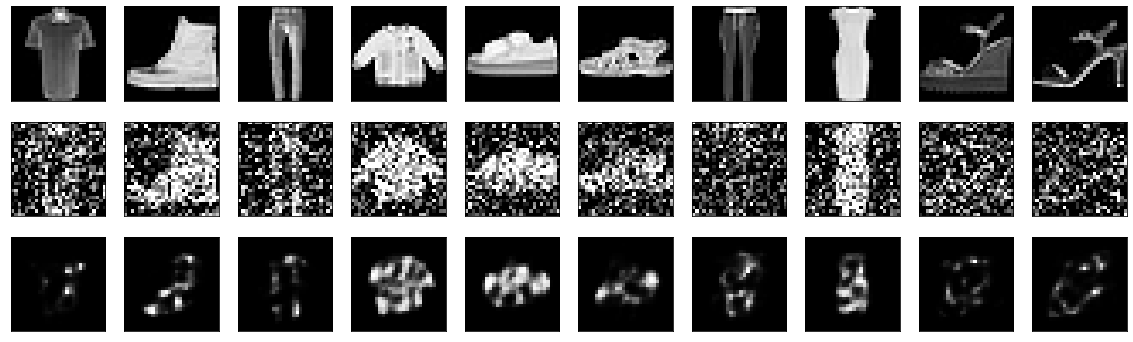

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
fa_encoded_imgs_adam = encoder_adam.predict(fa_X_test_noisy)
fa_decoded_imgs_adam = decoder_adam.predict(fa_encoded_imgs_adam)


n = 10  # How many digits we will display
plt.figure(figsize=(20, 6))
for i in range(k):

    # Display original
    ax = plt.subplot(3, n, i+1)
    plt.imshow(fa_X_test[id[i]].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display Noised
    ax = plt.subplot(3, n, i+1+n)
    plt.imshow(fa_X_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, n, i+1+n+n)
    plt.imshow(fa_decoded_imgs_adam[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()